<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/04_agentic_rag_finance_copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

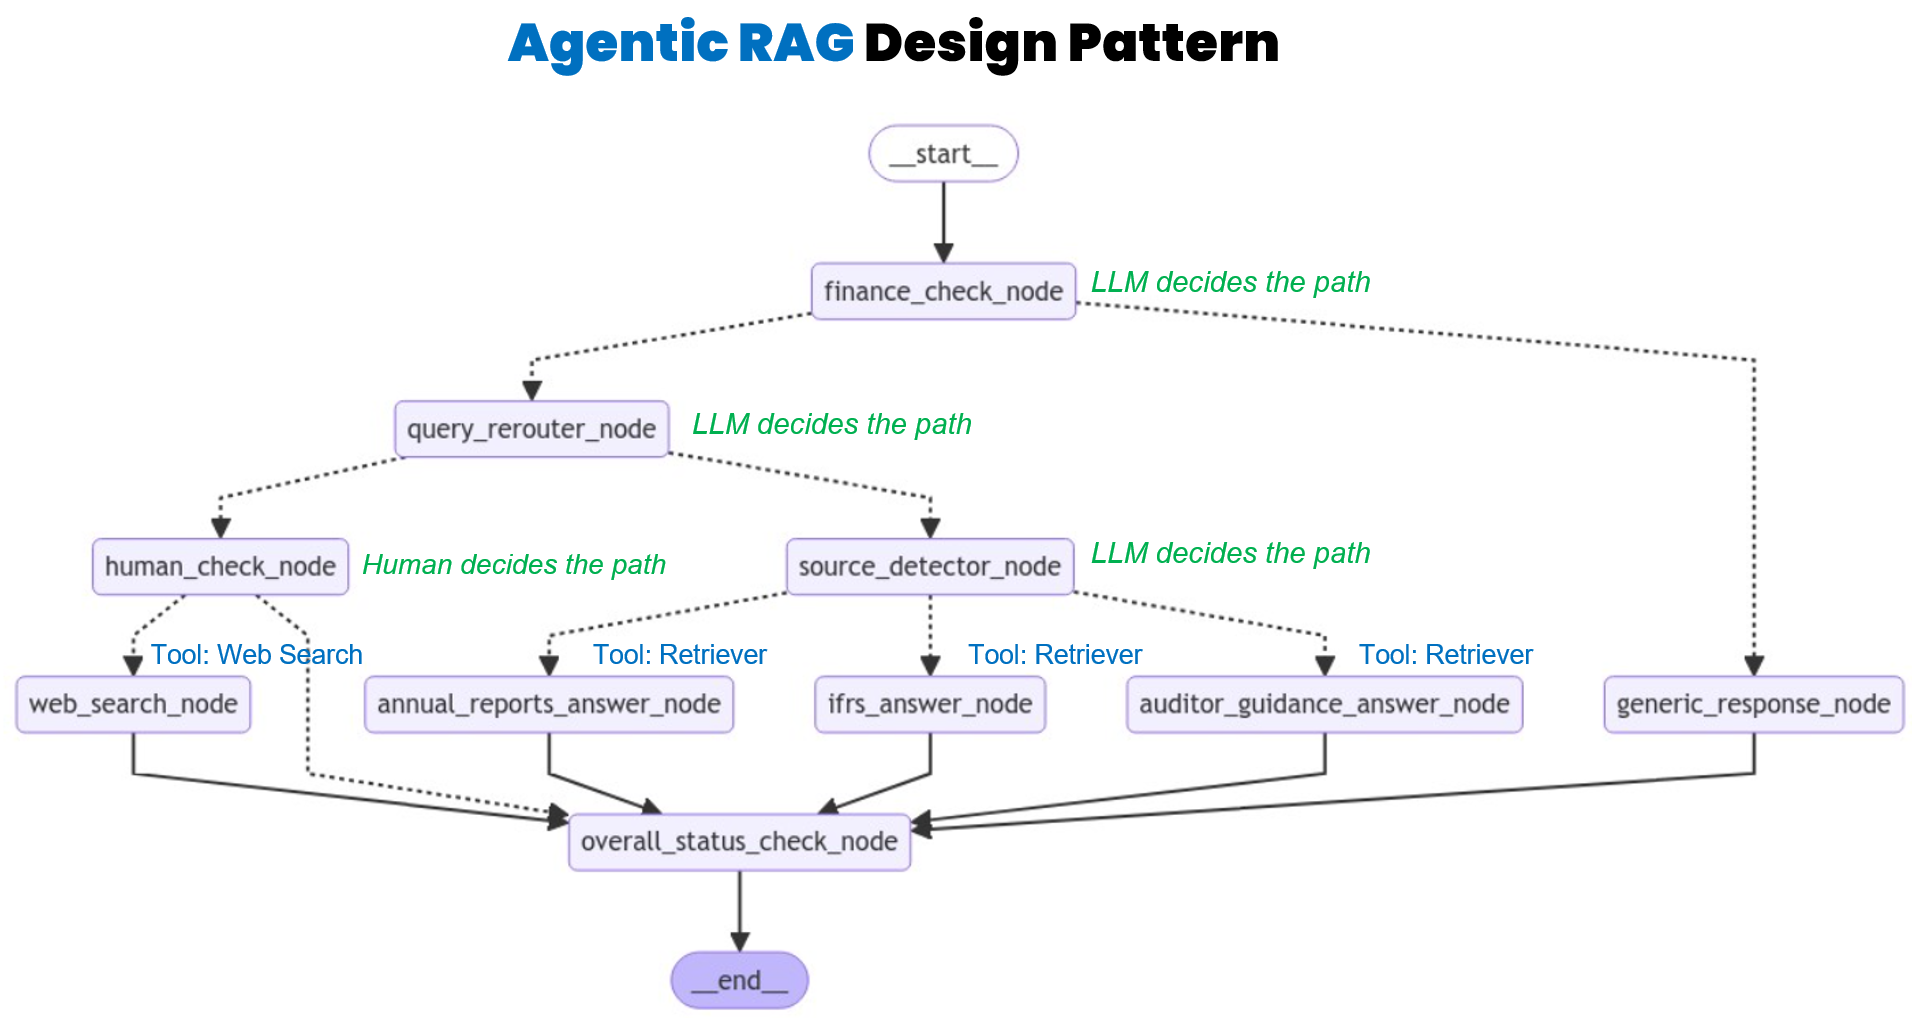

# Traditional RAG Workflow

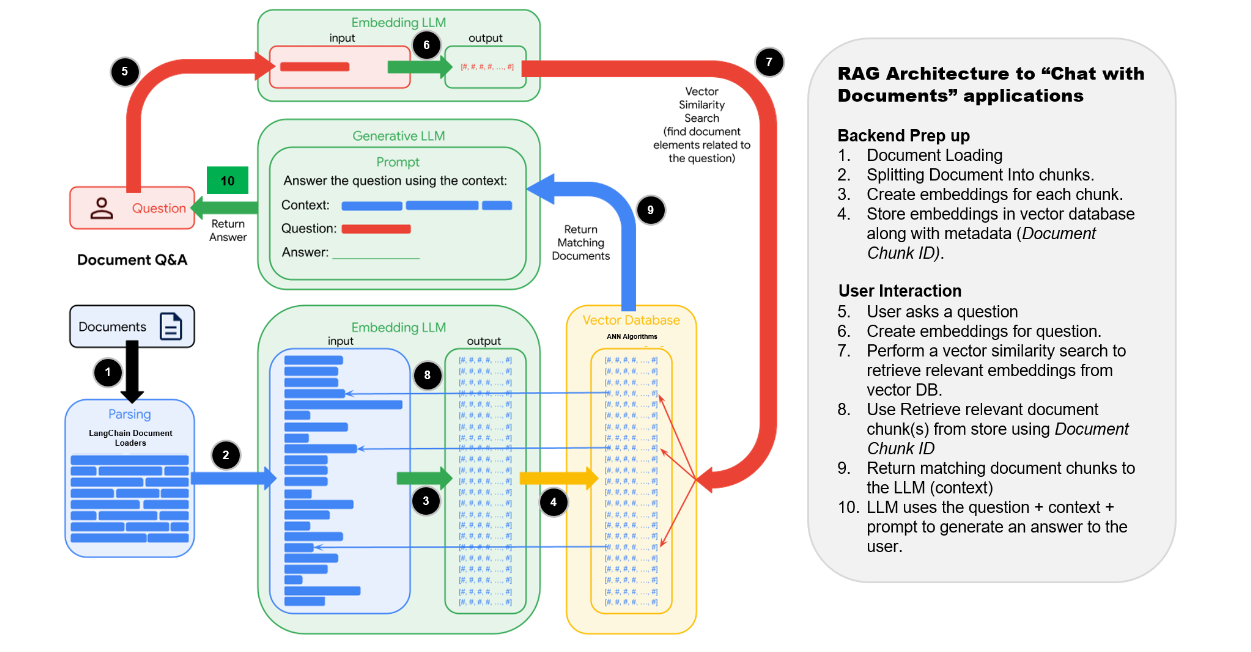

In [1]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

Cloning into 'AgenticAI_GenAIHack'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 270 (delta 98), reused 24 (delta 24), pack-reused 123
Receiving objects: 100% (270/270), 9.70 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [2]:
!pip install -q langchain==0.2.9 langchain-openai==0.1.7 langchain-chroma==0.1.2 langgraph==0.0.55 beautifulsoup4==4.12.2 tavily-python==0.3.5 python_dotenv==1.0.1 langchain-experimental==0.0.62 simple-colors==0.1.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0

#### Load environment variables

In [3]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv(dotenv_path="/content/.env")

llm  = ChatOpenAI(model="gpt-4o")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

#### Mount Google Drive to load the pre-saved vector store

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Define tools for agents

### Create tools to retrieve the content from the private data sources

**List of Private Data Sources**
* IFRS Documents
* Annual Reports of competitors
* Auditor guidance

**Public Data Sources**
* Tavily Web Search Tool


Change the below field to False to create vector store for the documents

```
vector_store_exists = False
```


In [6]:
from AgenticAI_GenAIHack.prompts import *
from AgenticAI_GenAIHack.utils import create_MVR, create_qa_agent, create_chat_agent

vector_store_exists = True #

_IFRS_ret = create_MVR('IFRS.pickle', embeddings, "IFRS", vectorstore_exists=vector_store_exists, k=7)

_annual_reports_ret = create_MVR('annual_reports.pickle', embeddings, "ANNUAL_REPORTS", vectorstore_exists=vector_store_exists, k=7)

_audit_ret = create_MVR('kpmg.pickle', embeddings, "KPMG", vectorstore_exists=vector_store_exists, k=7)

### Creating Retrivers as tools

In [7]:
from langchain.tools.retriever import create_retriever_tool

IFRS_tool = create_retriever_tool(retriever=_IFRS_ret,
                                  name = 'IFRS_Retriever',
                                  description="Use this tool to answer questions related to IFRS which is International Financial Reporting Standards.")

ANNUAL_REPORTS_tool = create_retriever_tool(retriever = _annual_reports_ret,
                                        name = "ANNUAL_REPORTS_RETRIEVER",
                                        description = "Use this tool when you need to answer questions related to annual reports, 10K reports or 20F reports of Novartis and it's competitors ('Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen','Abbvie', 'BMS' - Bristol Myers Squibb, 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk'). If no specific year is mentioned in the question, always look for latest available year")

AUDIT_tool = create_retriever_tool(retriever=_audit_ret,
                              name = 'AUDIT_Retriever',
                              description="Use this tool to answer questions related to the Auditor(KPMG, EY, PWC) Insights on IFRS which is International Financial Reporting Standards")

Inside any retriever or web search API as a tool

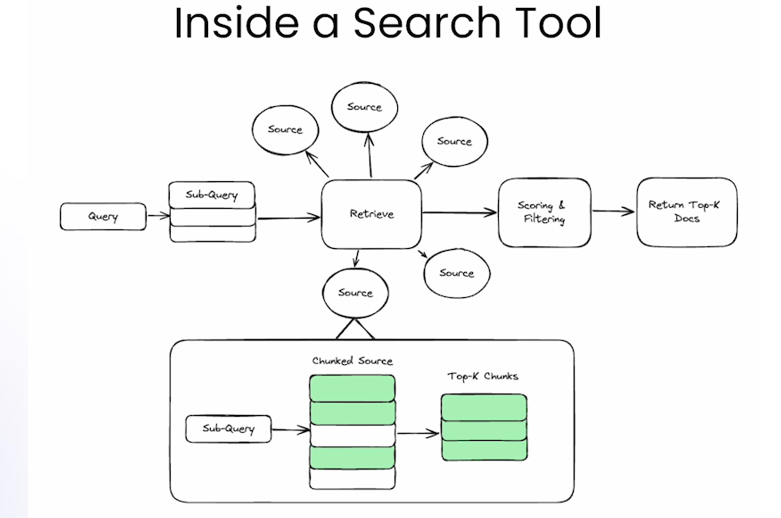

### Web Search Tool - Internet search and content processing


In [8]:
import json
import requests
from bs4 import BeautifulSoup
from langchain.tools import tool
from langchain_community.utilities import BingSearchAPIWrapper
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever


# Create a tool to processes content from a webpage
@tool("process_content", return_direct=False)
def process_content(url: str, chunk_size: int = 10000) -> str:
    """
    Use this tool to extract content from HTML pages and chunk it recursively.

    Args:
      url (str): The URL of the HTML page to process.
      chunk_size (int, optional): The maximum size of each text chunk. Defaults to 100000.

    Returns:
      str: The chunked text content extracted from the HTML page.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser',from_encoding="iso-8859-1")
    text = soup.get_text()

    def chunk_text(text, chunk_size):
        if len(text) <= chunk_size:
            return text
        else:
            midpoint = len(text) // 2
            left_chunk = chunk_text(text[:midpoint], chunk_size)
            right_chunk = chunk_text(text[midpoint:], chunk_size)
            return left_chunk + "\n" + right_chunk

        chunks = chunk_text(text, chunk_size)
        return chunks


@tool("bing_search", return_direct=False)
def bing_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    bing_search = BingSearchAPIWrapper()
    results = bing_search.results(query, 5)
    return results if results else "No results found."


# Create a tool to search the internet using TavilySearchAPI - Alternative to Bing Search
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool


# **Now Let's understand the step by step creation of a Graph**

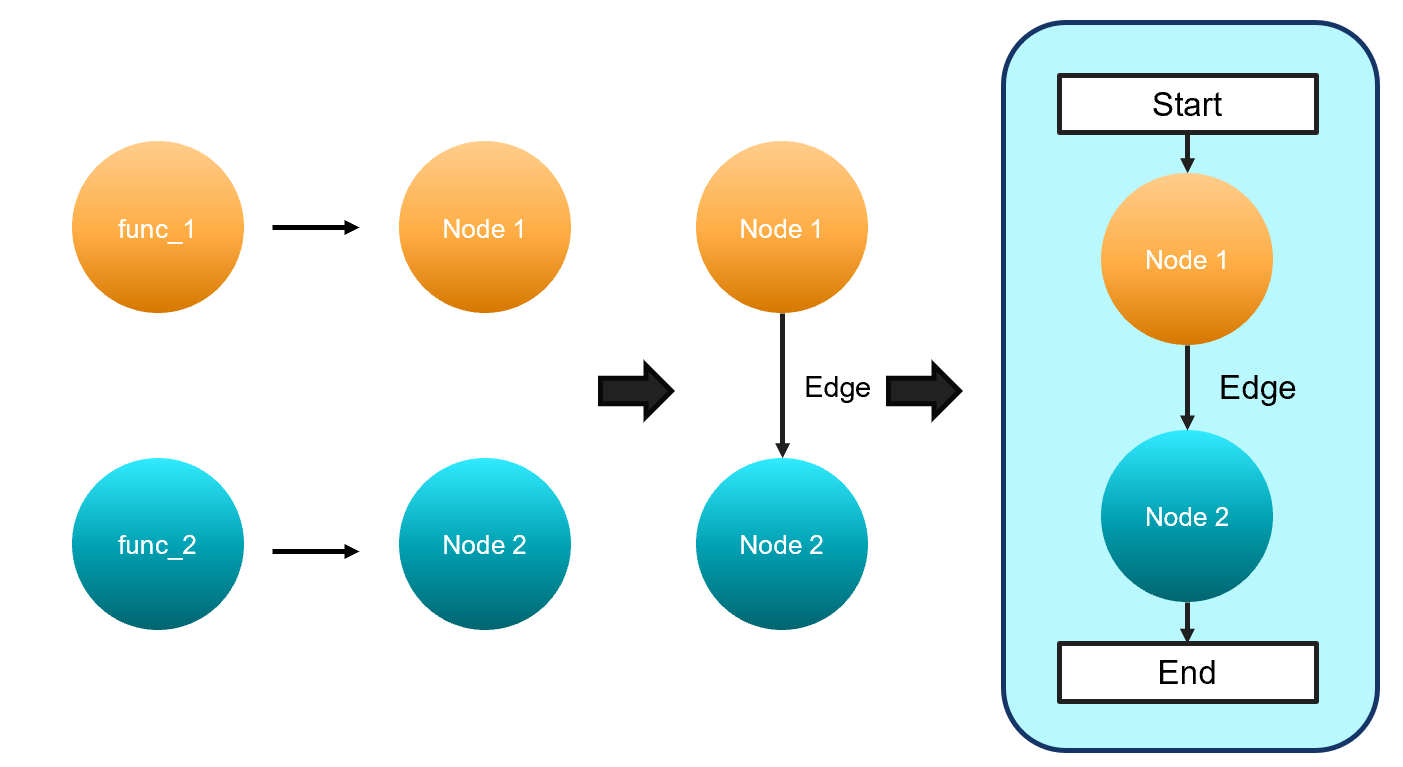

#### Define the functions to later convert them as Graph Nodes

In [9]:
import warnings
warnings.filterwarnings("ignore")

from simple_colors import *
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from IPython.display import Markdown
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser



class FinanceCheck_class(BaseModel):
    """Binary score for finance check on the user question."""
    binary_score: str = Field(description="Given a user question, return 'Yes' if is related to Finance/Accounting/Reporting else 'No'")


def get_finance_check(_llm, META_RESPONSE_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=FinanceCheck_class)
    prompt = PromptTemplate(template=META_RESPONSE_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},)
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    result = parser.invoke(output)
    return result.binary_score


def finance_check_node(state):
    """Use this tool to check whether the user question is about finance or general greeting."""
    observation = get_finance_check(llm, META_RESPONSE_PROMPT_DETAILED, state['question'])

    print("------ENTERING: FINANCE CHECK NODE------")
    print(f"------OBSERVATION: {observation}------")

    return {"finance_check": observation}


def generic_response_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC RESPONSE NODE------")

    answer = llm.invoke(META_ANSWER_PROMPT.format(question=question))
    final_answer = answer.content
    display(Markdown(f"""<font color="black">**GENERIC RESPONSE:**</font>"""))
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"generic_response": answer, "final_answer": final_answer}


class RouteQuery_class(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["FINANCE", "WEB"] = Field(description="Given a user question choose to route it to WEB or FRA.")

def get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=RouteQuery_class)

    prompt = PromptTemplate(template=QUERY_REROUTER_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    query_rerouter_check = parser.invoke(output)

    return query_rerouter_check.datasource

def query_rerouter_node(state):
    """Use this tool to check whether the user question needs an internet search to answer"""
    print("------ENTERING: QUERY REROUTER NODE------")
    observation = get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT_DETAILED, state['question'])

    print(f"------OBSERVATION: {observation}------")
    return {"query_rerouter_check": observation}

def human_check_node(state):
    user_input = input("The answer is not available from the private data sources! Do you want me to search over the internet to answer?")
    return {"human_response": user_input.lower()}

def get_web_search_answer(state):
    internet_search_tool = get_tavily_search_retriever()
    # tools = [bing_search, process_content]
    tools = [internet_search_tool, process_content]

    generate_prompt = """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                            Generate the best answer possible for the user's request with mandatory mention of the sources and the hyperlinks for the sources wherever it is possible.
                            Think step by step. Breakdown the question if it has multiple asks and finally merge your results.
                            Always crave for the best version of answer.
                            - **Always** before giving the final answer, try another method.Then reflect on the answers of the two methods you did and ask yourself if it answers correctly the original question. If you are not sure, try another method.
                            - If the methods tried do not give the same result, reflect and try again until you have two methods that have the same result.
                            - If you are sure of the correct answer, create a beautiful and thorough response.
                            ** DO NOT MAKE UP AN ANSWER OR USE YOUR PRIOR KNOWLEDGE, ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE **
                            PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.
                            """

    generate_agent = create_qa_agent(llm, tools, generate_prompt, verbose=False)
    answer = generate_agent.invoke({"input": state['question']})
    return answer['output']


def web_search_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB SEARCH NODE------")
    ## Write code here to get answer
    response = get_web_search_answer(state)
    print(f"------WEB SEARCH ANSWER: {response}------")
    display(Markdown(f"""<font color="Black">**WEB ANSWER:**</font>"""))
    display(Markdown(f"""<font color="green">{response}</font>"""))

    return {"web_response": response, "final_answer": response}


def get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT, selected_source_list, question):
    parser = JsonOutputParser()
    prompt = PromptTemplate(template=SOURCE_DETECTOR_PROMPT,
                            input_variables=["question"],
                            partial_variables={"role_based_sources": selected_source_list , "format_instructions": parser.get_format_instructions()},
                           )
    chain = prompt | llm | parser
    source_detector_check = chain.invoke({"question": question})
    print(source_detector_check)
    return source_detector_check['output']


def source_detector_node(state):
    """Use this tool to detect the sources needed for the question to answer"""
    print("------ENTERING: SOURCE DETECTOR NODE------")

    selected_source_list = ["ifrs_answer_node", "annual_reports_answer_node", "auditor_guidance_answer_node"]
    sources_detected = get_source_detector_check(llm, SOURCE_DETECTOR_PROMPT_DETAILED, selected_source_list, state['question'])
    print(f"------SOURCES DETECTED: {list(set(sources_detected))}------")
    return {"source_detector_check": list(set(sources_detected))}


def ifrs_answer_node(state):
    """Use this tool to answer ifrs related questions"""
    print("------ENTERING: IFRS ANSWER NODE------")

    tools = [IFRS_tool]
    generate_agent = create_qa_agent(llm, tools, IFRS_di_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**IFRS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"ifrs_response": answer['output'], 'final_answer':final_answer}


def auditor_guidance_answer_node(state):
    """Use this tool to answer audit related questions"""
    print("------ENTERING: AUDITOR GUIDANCE ANSWER NODE------")
    tools = [AUDIT_tool]
    generate_agent = create_qa_agent(llm, tools, KPMG_EY_PwC_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question']})
    final_answer = f"""**AUDITOR GUIDANCE ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"audit_response": answer['output'], 'final_answer':final_answer}


def annual_reports_answer_node(state):
    """Use this tool to answer annual reports related questions"""
    print("------ENTERING: ANNUAL REPORTS ANSWER NODE------")
    all_competitors = ['Roche','GSK','Bayer','AstraZeneca','Sanofi', 'Amgen', 'Biogen', 'Abbvie', 'BMS/Bristol Myers Squibb', 'Gilead', 'Eli Lilly', 'Merck', 'Pfizer', 'Takeda','Johnson&Johnson', 'novo-nordisk']

    competitors = ['Roche', 'Sanofi', 'Bayer', 'GSK', 'AstraZeneca']

    tools = [ANNUAL_REPORTS_tool]
    generate_agent = create_qa_agent(llm, tools, AR_prompt, verbose=False)
    answer = generate_agent.invoke({"input":state['question'], 'all_competitors':all_competitors, 'top5_competitors':competitors })
    final_answer = f"""**ANNUAL REPORTS ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"annual_reports_response": answer['output'], 'final_answer':final_answer}


def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    final_answer = state['final_answer']
    observation = "Completed"
    print("-------------------------------- {} --------------------------------".format(black("Final Answer", ['bold'])))
    display(Markdown(f"""**FINAL ANSWER:**\n\n <font color="green">{final_answer}</font>"""))

    return {"overall_status_check": observation, 'final_answer':final_answer}

# **Define the Graph State**

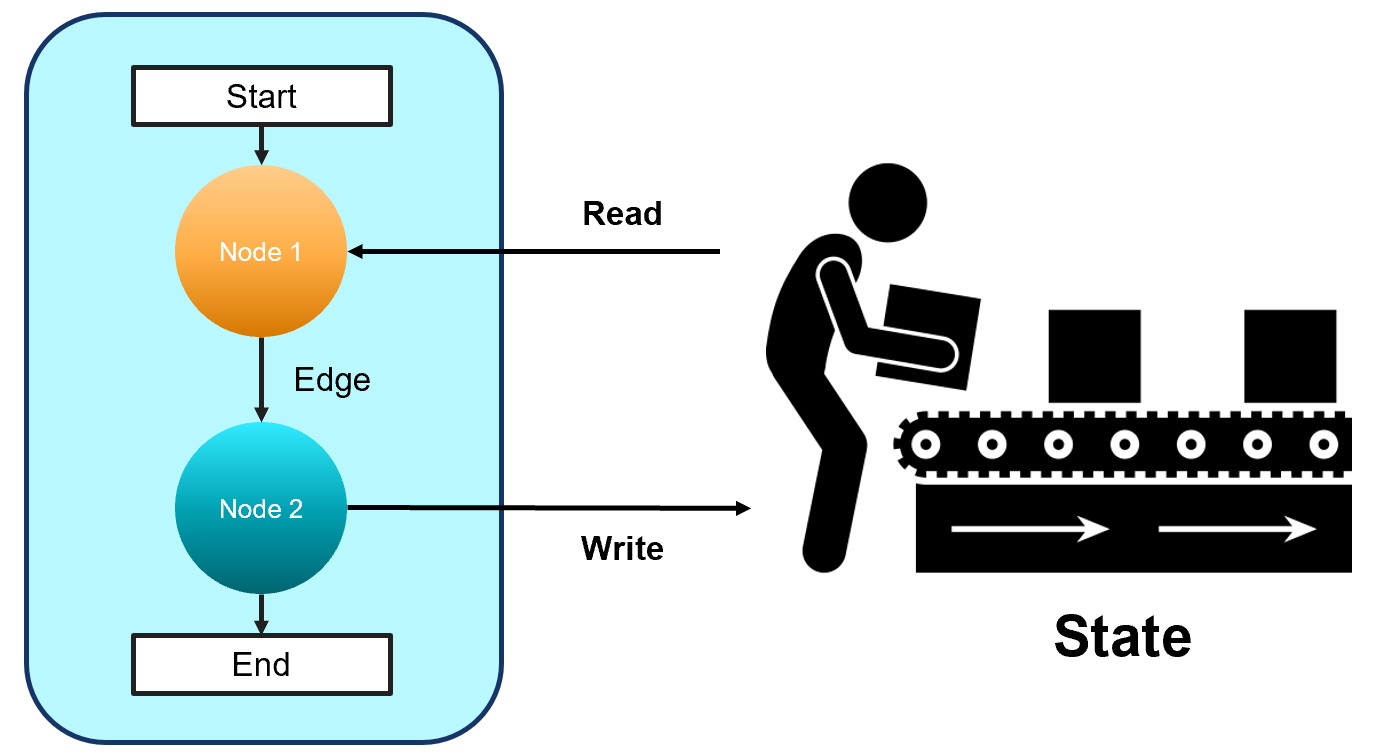

In [10]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
      question: User Question

      finance_check: Whether the user question is about finance or generic question
      query_rerouter_check: Check to assess the questions needs internal private data sources or seb search to answer
      source_detector_check: Check to assess what internal private sources to be needed to answer user question
      overall_status_check: Check to assess the overall graph completion

      generic_response: Generic answer
      human_response: Human response to search over internet
      web_response: Web search response
      ifrs_response: IFRS Response
      annual_reports_response: Annual Reports Response
      audit_response: Auditor Guidance Response
      final_answer: Final Answer
    """

    question: str

    finance_check: str
    query_rerouter_check: str
    source_detector_check: List[str]
    overall_status_check: str

    generic_response: str
    human_response: str
    web_response: str
    ifrs_response: str
    annual_reports_response: str
    audit_response: str
    final_answer: Annotated[str, operator.add]

# **Now construct the Graph architecture**

### First add all the nodes to the Graph

In [11]:
from langgraph.graph import StateGraph

builder = StateGraph(GraphState)
builder.add_node("finance_check_node", finance_check_node)
builder.add_node("generic_response_node", generic_response_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("human_check_node", human_check_node)
builder.add_node("web_search_node", web_search_node)
builder.add_node("source_detector_node", source_detector_node)
builder.add_node("ifrs_answer_node", ifrs_answer_node)
builder.add_node("annual_reports_answer_node", annual_reports_answer_node)
builder.add_node("auditor_guidance_answer_node", auditor_guidance_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

### Now define the workflow

In [12]:
from langgraph.checkpoint.sqlite import SqliteSaver

builder.set_entry_point("finance_check_node")

def finance_check_edge(state):
    if state["finance_check"] == "Yes":
        print("------DECISION: INVOKE QUERY REROUTER NODE------")
        return "query_rerouter_node"
    else:
        print("------DECISION: INVOKE GENERIC RESPONSE NODE------")
        return "generic_response_node"


finance_check_possible_nodes = ["query_rerouter_node", "generic_response_node"]
builder.add_conditional_edges("finance_check_node", finance_check_edge, finance_check_possible_nodes)
builder.add_edge("generic_response_node", "overall_status_check_node")


def query_rerouter_edge(state):
    if state["query_rerouter_check"] == "FINANCE":
        print("------DECISION: INVOKE SOURCE DETECTOR NODE------")
        return "source_detector_node"
    else:
        print("------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------")
        return "human_check_node"


query_rerouter_possible_nodes = ["human_check_node", "source_detector_node"]
builder.add_conditional_edges("query_rerouter_node", query_rerouter_edge, query_rerouter_possible_nodes)


def human_check_edge(state):
    if state['human_response'] == "yes":
        print("------DECISION: INVOKE WEB SEARCH NODE------")
        return "web_search_node"
    else:
        print("------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------")
        return "overall_status_check_node"


builder.add_conditional_edges("human_check_node", human_check_edge, ["web_search_node", "overall_status_check_node"])

builder.add_edge("web_search_node", "overall_status_check_node")


def source_detector_edge(state) -> list:
    return state["source_detector_check"]


individual_answer_nodes = ["annual_reports_answer_node", "ifrs_answer_node", "auditor_guidance_answer_node"]
builder.add_conditional_edges("source_detector_node", source_detector_edge, individual_answer_nodes)

for node in individual_answer_nodes:
    builder.add_edge(node, "overall_status_check_node")

builder.set_finish_point("overall_status_check_node")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

### Let's visualize the Graph

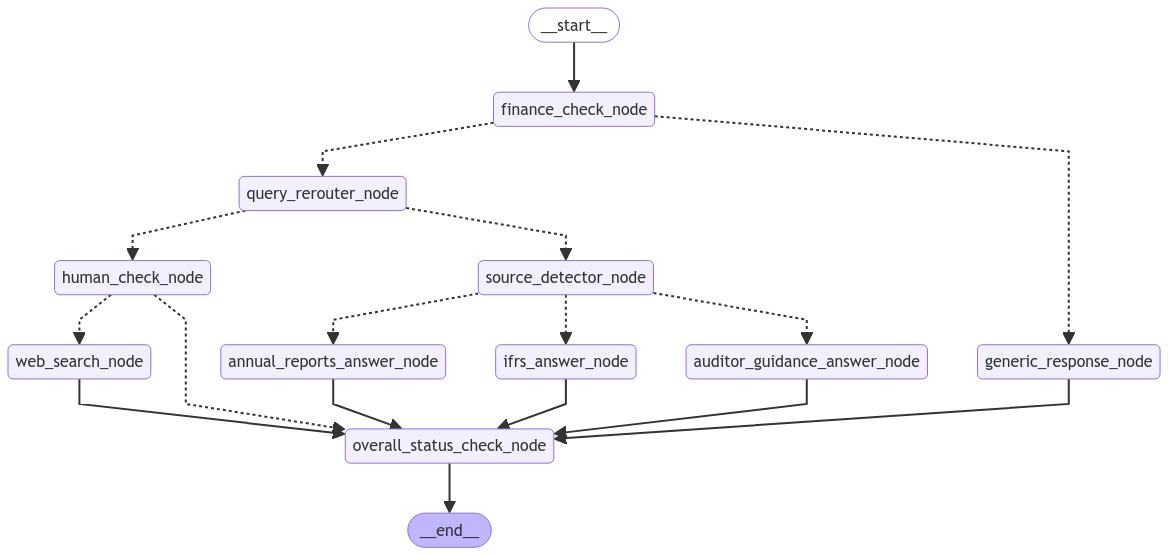

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Let's ask the questions now!

Thread ID helps in setting the memory thread

In [14]:
def run_graph(question, thread_id):
    inputs = {"question": question}
    thread = {"configurable": {"thread_id": str(thread_id)}}
    for output in graph.stream(inputs, thread, stream_mode='values'):
        pass

In [15]:
question = "Who are you?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: No------
------DECISION: INVOKE GENERIC RESPONSE NODE------
------ENTERING: GENERIC RESPONSE NODE------


<font color="black">**GENERIC RESPONSE:**</font>

<font color="green">Hello! I am Finance Copilot, a Generative AI powered assistant here to help finance professionals with technical accounting and financial process-related challenges. If you have any finance-related questions, please feel free to ask!</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">Hello! I am Finance Copilot, a Generative AI powered assistant here to help finance professionals with technical accounting and financial process-related challenges. If you have any finance-related questions, please feel free to ask!</font>

In [18]:
question = "What is the income of Dr Reddys Labs in 2024 Q1?"
run_graph(question,9)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: WEB------
------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------
The answer is not available from the private data sources! Do you want me to search over the internet to answer?yes
------DECISION: INVOKE WEB SEARCH NODE------
------ENTERING: WEB SEARCH NODE------
------WEB SEARCH ANSWER: Dr. Reddy's Laboratories Ltd. announced its consolidated financial results for the quarter ended June 30, 2023 (Q1 FY24). The key financial highlights for Q1 FY24 are:

- **Revenue**: The North American business reported a revenue of ₹32 billion, representing a year-over-year (YoY) growth of 79% and a quarter-over-quarter (QoQ) growth of 26%.
- **Net Profit**: The net profit for Q1 FY24 was ₹1,392 crore, which is nearly 4% higher than market expectations but shows a slight decline of 0.74% compared to the previous ye

<font color="Black">**WEB ANSWER:**</font>

<font color="green">Dr. Reddy's Laboratories Ltd. announced its consolidated financial results for the quarter ended June 30, 2023 (Q1 FY24). The key financial highlights for Q1 FY24 are:

- **Revenue**: The North American business reported a revenue of ₹32 billion, representing a year-over-year (YoY) growth of 79% and a quarter-over-quarter (QoQ) growth of 26%.
- **Net Profit**: The net profit for Q1 FY24 was ₹1,392 crore, which is nearly 4% higher than market expectations but shows a slight decline of 0.74% compared to the previous year.
- **Net Finance Income**: The net finance income for Q1 FY24 was ₹0.8 billion, compared to ₹2.3 billion in the same quarter of the previous year. The higher income in the previous year was primarily due to higher foreign exchange gains.

For more detailed information, you can refer to the official announcements and financial reports from Dr. Reddy's Laboratories.

Sources:
- [Dr. Reddy's Laboratories Q1 FY24 Financial Results](https://www.drreddys.com)
- [Earnings Call Transcript](https://www.nyse.com)

These sources provide comprehensive insights into the company's financial performance for the specified quarter.</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">Dr. Reddy's Laboratories Ltd. announced its consolidated financial results for the quarter ended June 30, 2023 (Q1 FY24). The key financial highlights for Q1 FY24 are:

- **Revenue**: The North American business reported a revenue of ₹32 billion, representing a year-over-year (YoY) growth of 79% and a quarter-over-quarter (QoQ) growth of 26%.
- **Net Profit**: The net profit for Q1 FY24 was ₹1,392 crore, which is nearly 4% higher than market expectations but shows a slight decline of 0.74% compared to the previous year.
- **Net Finance Income**: The net finance income for Q1 FY24 was ₹0.8 billion, compared to ₹2.3 billion in the same quarter of the previous year. The higher income in the previous year was primarily due to higher foreign exchange gains.

For more detailed information, you can refer to the official announcements and financial reports from Dr. Reddy's Laboratories.

Sources:
- [Dr. Reddy's Laboratories Q1 FY24 Financial Results](https://www.drreddys.com)
- [Earnings Call Transcript](https://www.nyse.com)

These sources provide comprehensive insights into the company's financial performance for the specified quarter.</font>

In [20]:
question = "What is the guidance for identifying a lease as per IFRS?"
run_graph(question, 99)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
{'Question': 'What is the guidance for identifying a lease as per IFRS?', 'output': ['ifrs_answer_node']}
------SOURCES DETECTED: ['ifrs_answer_node']------
------ENTERING: IFRS ANSWER NODE------


<font color="green">**IFRS ANSWER:** As per IFRS 16:

- **Paragraph 9**: At inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is, or contains, a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration.

- **Paragraph 12**: For a contract that is, or contains, a lease, an entity must account for each lease component within the contract as a lease separately from non-lease components of the contract.

- **Paragraph B9**: To assess whether a contract conveys the right to control the use of an identified asset, an entity must determine if the customer has both:
  - (a) The right to obtain substantially all of the economic benefits from use of the identified asset.
  - (b) The right to direct the use of the identified asset.

- **Paragraph B31**: The following flowchart assists in determining if a contract is, or contains, a lease:
  - Is there an identified asset?
  - Does the customer have the right to obtain substantially all of the economic benefits from use of the asset?
  - Does the customer, supplier, or neither have the right to direct how and for what purpose the asset is used?
  - Does the customer have the right to operate the asset throughout the period of use without the supplier having the right to change those operating instructions?
  - Did the customer design the asset in a way that predetermines how and for what purpose the asset will be used?

- **Paragraph B13**: An asset is typically identified by being explicitly specified in a contract but can also be identified implicitly when made available for use by the customer.

These paragraphs provide a comprehensive method for identifying a lease within a contract under IFRS 16. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**IFRS ANSWER:** As per IFRS 16:

- **Paragraph 9**: At inception of a contract, an entity must assess whether the contract is, or contains, a lease. A contract is, or contains, a lease if it conveys the right to control the use of an identified asset for a period of time in exchange for consideration.

- **Paragraph 12**: For a contract that is, or contains, a lease, an entity must account for each lease component within the contract as a lease separately from non-lease components of the contract.

- **Paragraph B9**: To assess whether a contract conveys the right to control the use of an identified asset, an entity must determine if the customer has both:
  - (a) The right to obtain substantially all of the economic benefits from use of the identified asset.
  - (b) The right to direct the use of the identified asset.

- **Paragraph B31**: The following flowchart assists in determining if a contract is, or contains, a lease:
  - Is there an identified asset?
  - Does the customer have the right to obtain substantially all of the economic benefits from use of the asset?
  - Does the customer, supplier, or neither have the right to direct how and for what purpose the asset is used?
  - Does the customer have the right to operate the asset throughout the period of use without the supplier having the right to change those operating instructions?
  - Did the customer design the asset in a way that predetermines how and for what purpose the asset will be used?

- **Paragraph B13**: An asset is typically identified by being explicitly specified in a contract but can also be identified implicitly when made available for use by the customer.

These paragraphs provide a comprehensive method for identifying a lease within a contract under IFRS 16. 

</font>

In [21]:
question = "How do I account for Gains on sales of fixed assets?"
run_graph(question, 92)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
{'output': ['ifrs_answer_node', 'auditor_guidance_answer_node', 'annual_reports_answer_node']}
------SOURCES DETECTED: ['auditor_guidance_answer_node', 'annual_reports_answer_node', 'ifrs_answer_node']------
------ENTERING: IFRS ANSWER NODE------------ENTERING: ANNUAL REPORTS ANSWER NODE------

------ENTERING: AUDITOR GUIDANCE ANSWER NODE------


<font color="green">**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

</font>

<font color="green">**IFRS ANSWER:** As per IAS 16, gains on sales of fixed assets (property, plant, and equipment) should be recognized at the date of derecognition of the asset. Specifically:

- Paragraph 71 of IAS 16 states that the gain or loss arising from the derecognition of an item of property, plant, and equipment shall be included in profit or loss when the item is derecognized.
- The gain or loss is determined as the difference between the net disposal proceeds, if any, and the carrying amount of the item.

Therefore, the accounting treatment for gains on sales of fixed assets should be as follows:
- Recognize the gain in profit or loss at the date the asset is derecognized.
- The gain is calculated as the difference between the net disposal proceeds and the carrying amount of the asset.

Source:
- IAS 16, Paragraph 71 

</font>

<font color="green">**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (KPMG, Page 90).
- The amount of consideration included in the gain or loss on derecognition and subsequent changes in that amount are estimated under the requirements for determining the transaction price in IFRS 15 (KPMG, Page 90).
- The gain or loss on derecognition as part of a sale transaction or withdrawal from use is generally included in profit or loss. Gains are not classified as revenue (KPMG, Page 90).

Therefore, gains on the sale of fixed assets should be recognized in profit or loss, not as revenue, and should reflect the difference between the net proceeds from the sale and the carrying amount of the asset. 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**IFRS ANSWER:** As per IAS 16, gains on sales of fixed assets (property, plant, and equipment) should be recognized at the date of derecognition of the asset. Specifically:

- Paragraph 71 of IAS 16 states that the gain or loss arising from the derecognition of an item of property, plant, and equipment shall be included in profit or loss when the item is derecognized.
- The gain or loss is determined as the difference between the net disposal proceeds, if any, and the carrying amount of the item.

Therefore, the accounting treatment for gains on sales of fixed assets should be as follows:
- Recognize the gain in profit or loss at the date the asset is derecognized.
- The gain is calculated as the difference between the net disposal proceeds and the carrying amount of the asset.

Source:
- IAS 16, Paragraph 71 

**ANNUAL REPORTS ANSWER:** NO GUIDANCE 

**AUDITOR GUIDANCE ANSWER:** As per IAS 16:

- When an item of property, plant, and equipment is disposed of or permanently withdrawn from use, a gain or loss is recognized for the difference between any net proceeds received and the carrying amount of the asset (KPMG, Page 90).
- The amount of consideration included in the gain or loss on derecognition and subsequent changes in that amount are estimated under the requirements for determining the transaction price in IFRS 15 (KPMG, Page 90).
- The gain or loss on derecognition as part of a sale transaction or withdrawal from use is generally included in profit or loss. Gains are not classified as revenue (KPMG, Page 90).

Therefore, gains on the sale of fixed assets should be recognized in profit or loss, not as revenue, and should reflect the difference between the net proceeds from the sale and the carrying amount of the asset. 

</font>

In [ ]:
question = "What is the revenue trend of GSK?"
run_graph(question, 19)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: SOURCE DETECTOR NODE------
{'Question': 'What is the revenue trend of GSK?', 'output': ['annual_reports_answer_node']}
------SOURCES DETECTED: ['annual_reports_answer_node']------
------ENTERING: ANNUAL REPORTS ANSWER NODE------


<font color="green">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020 - 2023)

#### 2023
- **Total Sales**: £30.3 billion
- **Growth**: +3% at AER (Actual Exchange Rates), +5% at CER (Constant Exchange Rates), +14% CER excluding COVID-19 solutions

#### 2022
- **Total Sales**: Not explicitly mentioned in the provided context for 2022. However, strong operational performance and growth in various segments were highlighted.

#### 2021
- **Total Sales**: Not explicitly mentioned in the provided context for 2021. Focus was on the demerger of the Consumer Healthcare business and its financial impacts.

#### 2020
- **Total Sales**: Not explicitly mentioned in the provided context for 2020. The focus was on the overall financial performance and strategic initiatives.

### Summary of Revenue Trend
- GSK has shown a consistent growth in sales from 2020 to 2023, with a significant increase driven by strong commercial execution and focus on operational performance.
- Excluding the effects of COVID-19 solutions, the growth rate in 2023 was substantial at 14% CER.
- The revenue trend for GSK indicates sustained performance momentum and a positive growth outlook for future years.

#### Citation
- GSK Annual Report 2023, page 31, 32, 80
 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">**ANNUAL REPORTS ANSWER:** ### Revenue Trend of GSK (2020 - 2023)

#### 2023
- **Total Sales**: £30.3 billion
- **Growth**: +3% at AER (Actual Exchange Rates), +5% at CER (Constant Exchange Rates), +14% CER excluding COVID-19 solutions

#### 2022
- **Total Sales**: Not explicitly mentioned in the provided context for 2022. However, strong operational performance and growth in various segments were highlighted.

#### 2021
- **Total Sales**: Not explicitly mentioned in the provided context for 2021. Focus was on the demerger of the Consumer Healthcare business and its financial impacts.

#### 2020
- **Total Sales**: Not explicitly mentioned in the provided context for 2020. The focus was on the overall financial performance and strategic initiatives.

### Summary of Revenue Trend
- GSK has shown a consistent growth in sales from 2020 to 2023, with a significant increase driven by strong commercial execution and focus on operational performance.
- Excluding the effects of COVID-19 solutions, the growth rate in 2023 was substantial at 14% CER.
- The revenue trend for GSK indicates sustained performance momentum and a positive growth outlook for future years.

#### Citation
- GSK Annual Report 2023, page 31, 32, 80
 

</font>